### THIS IS A SIMPLE COUPLING FRAMEWORK OF KU and ECSimpleSnow MODELS

### - Ku model is originally developed in Python, ANNUAL TIME STEP
### - ECSimpleSnow is developed in Fortran, DAILY TIME STEP

### Both them have BMI

#### *** ECSimpleSnow model 
#### - uses daily air temperature and precipitation as main inputs; 
#### - provides mean annual air temperature, annual amplitude of air temperature, winter-averged snow depth and density for ku model 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from permamodel.components import Ku_method

# Load PyMT model(s)
import pymt.models
ku = pymt.models.Ku()
ec = pymt.models.ECSimpleSnow()

ku_raw = Ku_method.Ku_method()

➡ models: FrostNumber, Ku, Hydrotrend, ECSimpleSnow, Cem, Waves


### This function is used to estimate the annual temperature curve:

In [2]:
def func(x, a, b, c):
    
    # a: annual amplitude
    # c: mean annual temperature
    
    return a * np.sin(x/365*2*np.pi+b) + c

### Initialize ECSimpleSnow component

In [3]:
# Call setup to get default config and data files.
# defaults = ec.setup('.')
# print(defaults)

# Initialize the model with the defaults.
ec.initialize('snow_model.cfg')

# List input and output variable names.
print(ec.get_output_var_names())
print(ec.get_input_var_names())

('snowpack__depth', 'snowpack__mass-per-volume_density')
('precipitation_mass_flux', 'land_surface_air__temperature', 'precipitation_mass_flux_adjust_factor', 'snow_class', 'open_area_or_not', 'snowpack__initial_depth', 'snowpack__initial_mass-per-volume_density')


### initialize KU component

In [4]:
config_file, run_folder = ku.setup(lat  = 71.31,
                                   lon  = -156.66) #Barrow as an example
ku.initialize(config_file, run_folder)
print(ku.get_component_name())

 
Ku model component: Initializing...
Permamodel Ku Component


### TRY to run snow model for a year

Air Temperature Unit: C
Snow Depth Unit: cm
Snow Density Unit: kg per m3
Snow Density is about  [ 366.84506]
Snow Depth is about  [ 0.1808421]
Mean Annual Air Temperature is  -9.33789954477  C
Annual Amplitude of Air Temperature is  15.9173143954  C
 
Ku model component: Initializing...
Active Layer Thickness: [ 0.38059217] m
Annual Mean Temperature at Permaforst Surface: [-8.88533451] deg_C
Air Temperature Unit: C
Snow Depth Unit: cm
Snow Density Unit: kg per m3
Snow Density is about  [ 366.84506]
Snow Depth is about  [ 0.1808421]
Mean Annual Air Temperature is  -9.33789954477  C
Annual Amplitude of Air Temperature is  15.9173143954  C
 
Ku model component: Initializing...
Active Layer Thickness: [ 0.38059217] m
Annual Mean Temperature at Permaforst Surface: [-8.88533451] deg_C
Air Temperature Unit: C
Snow Depth Unit: cm
Snow Density Unit: kg per m3
Snow Density is about  [ 366.84506]
Snow Depth is about  [ 0.1808421]
Mean Annual Air Temperature is  -9.33789954477  C
Annual Amplitude 

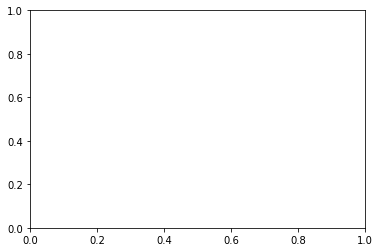

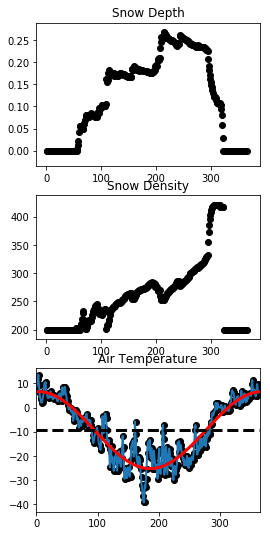

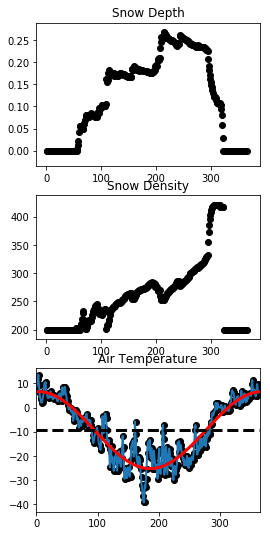

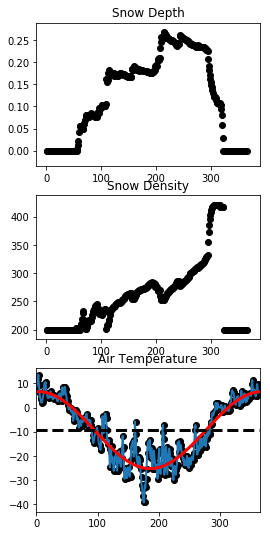

In [5]:
fig, ax = plt.subplots()

for ii in np.arange(3): # loop for each column
    
    ec.initialize('snow_model.cfg')
    
    plt.figure(figsize=[4,9])
    h0 = plt.subplot(3,1,1)
    h1 = plt.subplot(3,1,2)
    h2 = plt.subplot(3,1,3)

    h0.title.set_text('Snow Depth')
    h1.title.set_text('Snow Density')
    h2.title.set_text('Air Temperature')

    # DEFINE some variables for annual summary

    snod     = 0
    sden     = 0
    snow_day = 0

    air_temperature = np.zeros(365) # this is used for estimating annual cycle in following

    print('Air Temperature Unit:', ec.get_var_units('land_surface_air__temperature'))
    print('Snow Depth Unit:'     , ec.get_var_units('snowpack__depth'))
    print('Snow Density Unit:'   , ec.get_var_units('snowpack__mass-per-volume_density'))

    for i in np.arange(365):

        ec.update()

        tair  = ec.get_value('land_surface_air__temperature')    
        snd   = ec.get_value('snowpack__depth', units='m')
        rsn   = ec.get_value('snowpack__mass-per-volume_density')

        air_temperature[i] = tair

        units = ec.get_var_units('snowpack__depth')

        h0.scatter(ec.time, snd, c='k')    
        h1.scatter(ec.time, rsn, c='k')
        h2.scatter(ec.time,tair, c='k')

        snod = snod + snd
        sden = sden + rsn

        if tair <= 0:
            snow_day = snow_day + 1
            
    ec.finalize()

    # Calculate winter-averaged snow depth and density:

    SDEN = sden / snow_day 
    SNOD = snod / snow_day

    print('Snow Density is about ', SDEN)
    print('Snow Depth is about ',   SNOD)
    
    t365 = np.arange(365)

    popt, pcov = curve_fit(func, 
                           t365, 
                           air_temperature, 
                           bounds=([0.0,-99.0,-99.0], [50., 99.0, 99.0]))

    MAAT = popt[2]
    MAAA = popt[0]

    print('Mean Annual Air Temperature is ', MAAT,' C')
    print('Annual Amplitude of Air Temperature is ', MAAA, ' C')

    plt.plot(t365, air_temperature  ,       linewidth = 2)
    plt.plot(t365, func(t365,*popt) ,'r-' , linewidth = 3)
    plt.plot(t365, MAAT + 0 * t365  ,'k--', linewidth = 3)

    plt.xlim([0,365])
    
    ku.initialize(config_file, run_folder)

    ku.set_value('atmosphere_bottom_air__temperature'          , MAAT)
    ku.set_value('atmosphere_bottom_air__temperature_amplitude', MAAA)
    ku.set_value('snowpack__depth'                             , SNOD)
    ku.set_value('snowpack__density'                           , SDEN)
    ku.set_value('water-liquid__volumetric-water-content-soil' , 0.45)
    ku.set_value('vegetation__Hvgf'                            , 0.00)
    ku.set_value('vegetation__Hvgt'                            , 0.10)

    #cfg_file = run_folder + '/' + config_file

    #%cat $cfg_file

    ku.update()

    ALT = ku.get_value('soil__active_layer_thickness')
    print('Active Layer Thickness:', 
          ALT, 
          ku.get_var_units('soil__active_layer_thickness'))

    TPS = ku.get_value('soil__temperature')
    print('Annual Mean Temperature at Permaforst Surface:', 
          TPS, 
          ku.get_var_units('soil__temperature'))
    
#     ax.add_sscatter(ii, ALT)
    
    

### Estimate annual temperature cycle

Mean Annual Air Temperature is  -9.33789954477  C
Annual Amplitude of Air Temperature is  15.9173143954  C


(0, 365)

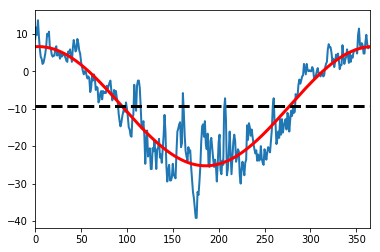

In [6]:
t365 = np.arange(365)

popt, pcov = curve_fit(func, 
                       t365, 
                       air_temperature, 
                       bounds=([0.0,-99.0,-99.0], [50., 99.0, 99.0]))

MAAT = popt[2]
MAAA = popt[0]

print('Mean Annual Air Temperature is ', MAAT,' C')
print('Annual Amplitude of Air Temperature is ', MAAA, ' C')

plt.plot(t365, air_temperature  ,       linewidth = 2)
plt.plot(t365, func(t365,*popt) ,'r-' , linewidth = 3)
plt.plot(t365, MAAT + 0 * t365  ,'k--', linewidth = 3)

plt.xlim([0,365])

### Run Ku model

Using the results from EC snow model.

In [7]:
ku.initialize(config_file, run_folder)

ku.var

ku.set_value('atmosphere_bottom_air__temperature'          , MAAT)
ku.set_value('atmosphere_bottom_air__temperature_amplitude', MAAA)
ku.set_value('snowpack__depth'                             , SNOD)
ku.set_value('snowpack__density'                           , SDEN)
ku.set_value('water-liquid__volumetric-water-content-soil' , 0.45)
ku.set_value('vegetation__Hvgf'                            , 0.00)
ku.set_value('vegetation__Hvgt'                            , 0.10)

cfg_file = run_folder + '/' + config_file

#%cat $cfg_file

ku.update()

ALT = ku.get_value('soil__active_layer_thickness')
print('Active Layer Thickness:', 
      ALT, 
      ku.get_var_units('soil__active_layer_thickness'))

TPS = ku.get_value('soil__temperature')
print('Annual Mean Temperature at Permaforst Surface:', 
      TPS, 
      ku.get_var_units('soil__temperature'))

 
Ku model component: Initializing...
Active Layer Thickness: [ 0.38059217] m
Annual Mean Temperature at Permaforst Surface: [-8.88533451] deg_C


**Observed ALT : 0.40 m**

**Observed MAGT: -9.0 C**